In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import dask.array as da
from IPython.display import Image
from rasterio.enums import Resampling
import shapely
from pystac import Catalog
import pystac
import xarray as xr
from rich.progress import track
import rich.progress
import rioxarray as rxr
import rasterio as rio
import requests
import cartopy.crs as ccrs
from shapely import Polygon

# Accessing Data with STAC

In [2]:
url = "https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/industry/mining/wyvern_dragonette-001_20240620T145630_2d5d0eef/wyvern_dragonette-001_20240620T145630_2d5d0eef.json"

#Reading the URL
img = pystac.Item.from_file(url)

img

<Item id=wyvern_dragonette-001_20240620T145630_2d5d0eef>

In [3]:
img.assets

{'Cloud optimized GeoTiff': <Asset href=https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-001_20240620T145630_2d5d0eef/wyvern_dragonette-001_20240620T145630_2d5d0eef.tiff>,
 'Overview image': <Asset href=https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-001_20240620T145630_2d5d0eef/wyvern_dragonette-001_20240620T145630_2d5d0eef_preview.png>,
 'Thumbnail image': <Asset href=https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-001_20240620T145630_2d5d0eef/wyvern_dragonette-001_20240620T145630_2d5d0eef_thumbnail.png>,
 'Data Mask': <Asset href=https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-001_20240620T145630_2d5d0eef/wyvern_dragonette-001_20240620T145630_2d5d0eef_data_mask.tiff>,
 'Pixel Quality Mask': <Asset href=https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-001_20240620T

In [4]:
thumbnail = img.assets['Thumbnail image'].href

Image(url = thumbnail)

In [5]:
img.assets['Cloud optimized GeoTiff']

<Asset href=https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-001_20240620T145630_2d5d0eef/wyvern_dragonette-001_20240620T145630_2d5d0eef.tiff>

In [6]:
geotiff = img.assets['Cloud optimized GeoTiff'].href

geotiff

'https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-001_20240620T145630_2d5d0eef/wyvern_dragonette-001_20240620T145630_2d5d0eef.tiff'

In [7]:
Image(url = geotiff)

In [8]:
rimg = rxr.open_rasterio(geotiff)

In [9]:
rimg

<xarray.DataArray (band: 23, y: 9623, x: 6207)> Size: 5GB
[1373789103 values with dtype=float32]
Coordinates:
  * band         (band) int64 184B 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23
  * x            (x) float64 50kB -69.22 -69.22 -69.22 ... -68.92 -68.92 -68.92
  * y            (y) float64 77kB -24.15 -24.15 -24.15 ... -24.59 -24.59 -24.59
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:     Area
    FWHM:              20.12
    wavelength:        503
    wavelength_units:  nm
    _FillValue:        -9999.0
    scale_factor:      1.0
    add_offset:        0.0
    long_name:         ('Band_503', 'Band_510', 'Band_519', 'Band_535', 'Band...

In [10]:
#Amout of dimensions
rimg.dims

('band', 'y', 'x')

In [11]:
x_coords = rimg.x.values
y_coords = rimg.y.values
x_min, x_max = np.min(x_coords), np.max(x_coords)
y_min, y_max = np.min(y_coords), np.max(y_coords)

bbox_polygon = Polygon([(x_min, y_min),
                         (x_min, y_max),
                         (x_max, y_max),
                         (x_max, y_min),
                         (x_min, y_min)])

gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs=rimg.rio.crs)
gdf

,geometry
0,"POLYGON ((-69.22257 -24.58785, -69.22257 -24.1..."


In [12]:
gdf.explore()

# Downloading Data

In [13]:
stac_response = requests.get(url)

stac_item = stac_response.json()

download_url = stac_item["assets"]["Cloud optimized GeoTiff"]["href"]
local_filename = download_url.split("/")[-1]

#Already downloaded! 
#with requests.get(download_url, stream = True) as r:
#    r.raise_for_status()
#    with open(local_filename, "wb") as f:
#        for chunk in track(r.iter_content(chunk_size = 8192)):
#            f.write(chunk)

In [14]:
#Opening with Rioxarray

file = "wyvern_dragonette-001_20240620T145630_2d5d0eef.tiff"
rds = rxr.open_rasterio(file)
rds

<xarray.DataArray (band: 23, y: 9623, x: 6207)> Size: 5GB
[1373789103 values with dtype=float32]
Coordinates:
  * band         (band) int64 184B 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23
  * x            (x) float64 50kB -69.22 -69.22 -69.22 ... -68.92 -68.92 -68.92
  * y            (y) float64 77kB -24.15 -24.15 -24.15 ... -24.59 -24.59 -24.59
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:     Area
    FWHM:              20.12
    wavelength:        503
    wavelength_units:  nm
    _FillValue:        -9999.0
    scale_factor:      1.0
    add_offset:        0.0
    long_name:         ('Band_503', 'Band_510', 'Band_519', 'Band_535', 'Band...

In [19]:
rds.band

<xarray.DataArray 'band' (band: 23)> Size: 184B
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23])
Coordinates:
  * band         (band) int64 184B 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23
    spatial_ref  int64 8B 0

In [24]:
rds.band.value

AttributeError: 'DataArray' object has no attribute 'value'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9999.0..334.32294].


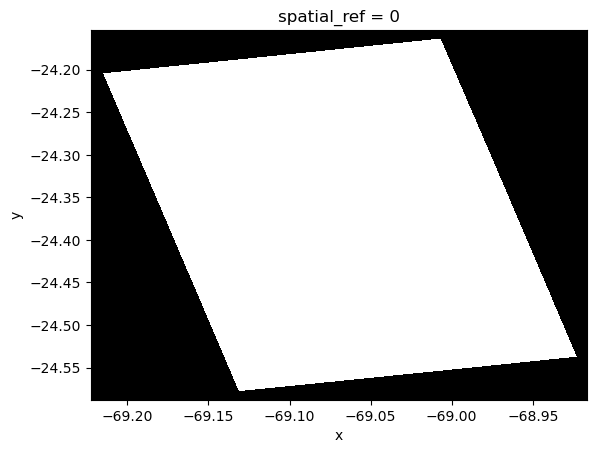

In [23]:
rds.sel(band=[10,4,1]).plot.imshow()

# Analyzing Data

# Resources

- [Wyvern Image STAC Index](https://stacindex.org/catalogs/wyvern-open-data#/item/7V2FRzuKLCHKhpD5SVu57Ky3p1f9P/2cF9VwitbHB8NBvnVztdY21VsF7zQxvRyRKPV1FgEjX/7edikfz7V6zLif8MwPbWtH55ZGSY9kRAygg19qNVzg8jz3dpNnirtUj8gHkiNLqzfbivmNGHe3zeFKXM9nuxj2USfUgV6HfCydejaMm2zL2KXFrGsXjGkiLXPpjPiEcnfb6ZHtbWMigRHdiVQEBV8v4hgopR?si=0#10/-24.370663/-69.069114)

- [STAC Across Languages](https://loreabad6.github.io/posts/2023-10-17-stac-across-languages/)

- [Wyvern Open Data Feed](https://tech.marksblogg.com/wyvern-open-data-feed.html)

- [How to Read Data From STAC](https://pystac.readthedocs.io/en/stable/tutorials/how-to-read-data-from-stac.html)

- [Wyvern Loading and Viewing Images in Python](https://knowledge.wyvern.space/#/using_wyvern_data/python/loading_data)